## XGBoost regressor for 1-h wind-speed forecast

In [1]:
import numpy as np
import pandas as pd


In [2]:
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

In [3]:
df = pd.read_csv("../../../data/cleaned/wind_hourly_cleaned.csv")
df = df.sort_values('datetime').reset_index(drop=True)
df['wind_speed'] = df['wind_speed'].astype(float)

In [4]:
LAGS = [1,2,3,23,24,25,48]
df = df.join(make_lags(df[['wind_speed']], ['wind_speed'], LAGS)).dropna()

In [5]:
df.head()

,datetime,wind_speed,wind_speed_L1,wind_speed_L2,wind_speed_L3,wind_speed_L23,wind_speed_L24,wind_speed_L25,wind_speed_L48
48,2024-01-03 00:00:00,0.100000,0.800000,1.000000,0.216667,0.933333,1.050000,0.716667,0.100000
49,2024-01-03 01:00:00,0.616667,0.100000,0.800000,1.000000,0.700000,0.933333,1.050000,0.283333
50,2024-01-03 02:00:00,0.500000,0.616667,0.100000,0.800000,1.450000,0.700000,0.933333,0.200000
51,2024-01-03 03:00:00,0.033333,0.500000,0.616667,0.100000,1.750000,1.450000,0.700000,0.500000
52,2024-01-03 04:00:00,0.116667,0.033333,0.500000,0.616667,0.083333,1.750000,1.450000,0.966667


In [6]:
# ensure the column is datetime *type*
df['date'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['date'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [7]:
# 3. train/test split (last 720 rows locked)
train_end = len(df) - 720
test_df = df.iloc[train_end:].copy()

FEATS = [c for c in df.columns if '_L' in c] + ['sin_h', 'cos_h']


In [8]:
from xgboost import XGBRegressor
param = {
    'n_estimators': [200, 400],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}  # 8 combos

In [11]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [14]:
# 1. Define your main training set
train_df = df.iloc[:train_end]
X_train_main = train_df[FEATS].values
y_train_main = train_df['wind_speed'].values

# 2. Run GridSearchCV ONCE on this large set
tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1),
                  param, cv=tscv, scoring='neg_mean_absolute_error', verbose=3)

gs.fit(X_train_main, y_train_main)

# 3. Get the SINGLE best parameter set
best_params = gs.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.827 total time=   1.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.732 total time=   1.4s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.567 total time=   1.3s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.619 total time=   1.9s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.706 total time=   2.5s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0;, score=-0.821 total time=   1.6s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0;, score=-0.737 total time=   3.6s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0;, score=-0.571 total time=   2.7s
[CV 4/5] END learning_rate=0.05, max_depth=

In [15]:
# 4. Create the final model instance
final_model = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1, **best_params)

preds = []
for t in range(train_end, len(df)):
    # Get rolling window
    w = df.iloc[t-168:t] 
    X_train_window, y_train_window = w[FEATS].values, w['wind_speed'].values

    # Fit the model with the *best_params*
    final_model.fit(X_train_window, y_train_window) 

    # Predict the next step
    x_next = df.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(final_model.predict(x_next)[0])

test_df['pred_xgb'] = preds
# print('XGB MAE :', m.mean_absolute_error(test_df['wind_speed'], test_df['pred_xgb']))

NameError: name 'm' is not defined

In [12]:
from sklearn import metrics as m

In [17]:
test_df['pred_xgb'] = preds
print('XGB MAE :', m.mean_absolute_error(test_df['wind_speed'], test_df['pred_xgb']))

XGB MAE : 0.729171165451666


In [18]:
'''
⚠️ Note: This grid search runs only once on the initial training set.
It assumes the best hyperparameters won’t change over time. 
'''
# 1. Main training
train_df = df.iloc[:train_end]
X_train_main = train_df[FEATS].values
y_train_main = train_df['wind_speed'].values

# 2. One-time GridSearch
tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(
    XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1),
    param,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=3
)
gs.fit(X_train_main, y_train_main)
best_params = gs.best_params_
print(f"Best parameters: {best_params}")

# 3. Rolling retraining every 168 hours
final_model = XGBRegressor(objective='reg:absoluteerror', random_state=42,
                           n_jobs=-1, **best_params)

preds = []
model = None

for t in range(train_end, len(df)):

    # retrain every 168 hours (weekly)
    if (t - train_end) % 168 == 0:
        w = df.iloc[:t]       # all available history
        X_train_window = w[FEATS].values
        y_train_window = w['wind_speed'].values

        model = XGBRegressor(objective='reg:absoluteerror', random_state=42,
                             n_jobs=-1, **best_params)
        model.fit(X_train_window, y_train_window)

    # prediction
    x_next = df.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(model.predict(x_next)[0])

test_df['pred_xgb'] = preds
print("XGB MAE:", m.mean_absolute_error(test_df['wind_speed'], test_df['pred_xgb']))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.827 total time=   0.9s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.732 total time=   1.2s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.567 total time=   1.3s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.619 total time=   1.3s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;, score=-0.706 total time=   1.6s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0;, score=-0.821 total time=   1.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0;, score=-0.737 total time=   1.3s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0;, score=-0.571 total time=   1.1s
[CV 4/5] END learning_rate=0.05, max_depth=

In [24]:
print("XGB MAE:", m.mean_absolute_error(test_df['wind_speed'], test_df['pred_xgb']))

XGB MAE: 0.6507182700904431


In [21]:
import matplotlib.pyplot as plt

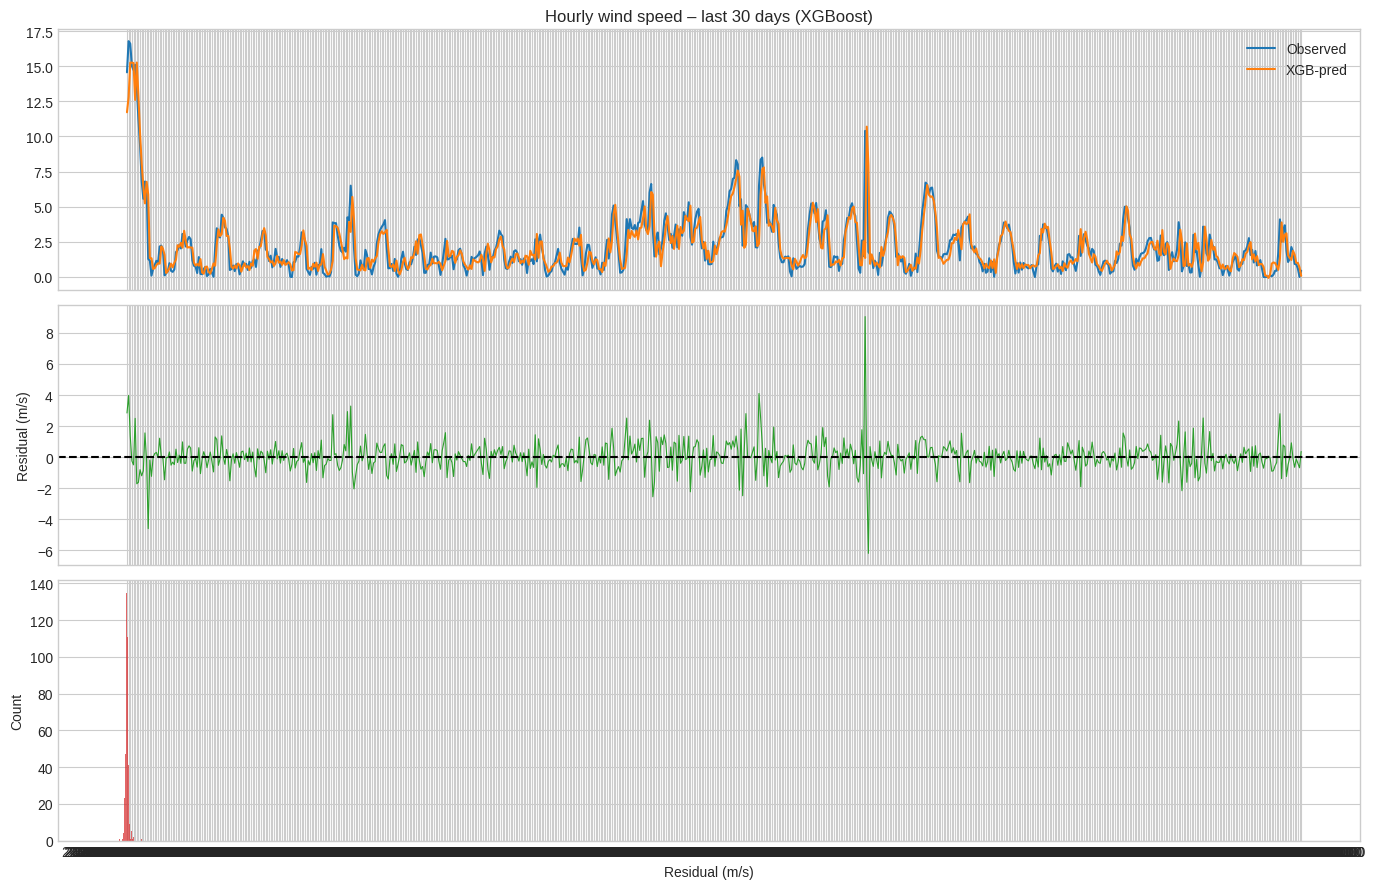

In [22]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(3,1, figsize=(14,9), sharex=True)

# 1. raw series vs XGBoost forecast
ax[0].plot(test_df['datetime'], test_df['wind_speed'], label='Observed')
ax[0].plot(test_df['datetime'], test_df['pred_xgb'], label='XGB-pred')
ax[0].set_title('Hourly wind speed – last 30 days (XGBoost)')
ax[0].legend()

# 2. residuals (Observed - Predicted)
resid = test_df['wind_speed'] - test_df['pred_xgb']
ax[1].plot(test_df['datetime'], resid, color='C2', lw=0.8)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_ylabel('Residual (m/s)')

# 3. residual histogram
ax[2].hist(resid, bins=50, alpha=0.7, color='C3')
ax[2].set_xlabel('Residual (m/s)')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('xgb_vs_obs.png', dpi=150)
plt.show()

In [23]:
# --- SAVING THE MODEL ---
model.save_model('xgb_model_v1.json')

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats # Used for parameter distributions

# --- Assumed Setup (from your original code) ---
# df = ... (your DataFrame)
# FEATS = [...] (your list of feature names)
# train_end = ... (the index where initial training ends)
# test_df = df.iloc[train_end:].copy()
# m = ... (your metrics module, e.g., sklearn.metrics)
# -------------------------------------------------

### 1. Define Parameter Distribution for RandomizedSearch
# We use distributions (like uniform, loguniform) instead of a fixed grid
# This is much faster and more efficient for periodic tuning.
param_dist = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.loguniform(0.01, 0.3),
    'subsample': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'colsample_bytree': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'gamma': stats.uniform(0, 0.5),
    'reg_alpha': stats.loguniform(1e-3, 1.0),
    'reg_lambda': stats.loguniform(1e-3, 1.0),
}

### 2. Define Tuning and Retraining Settings
RETRAIN_INTERVAL = 168 # hours (weekly)
TUNING_WINDOW_HOURS = 2160 # Approx 3 months for tuning
N_ITER_RANDOM_SEARCH = 15 # Number of param combinations to try (faster)
N_SPLITS_INNER_CV = 3 # Fewer splits for speed during tuning


In [9]:

### 3. Rolling Retraining and Re-Tuning Loop
print("Starting rolling forecast with periodic re-tuning...")

preds = []
model = None # Start with no model
current_best_params = {} # Will be set on the first run

for t in range(train_end, len(df)):

    # Check if it's time to retrain and re-tune
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- Retraining and Re-Tuning at index {t} ---")
        
        # --- A. RE-TUNING on a SLIDING window ---
        # We tune on a *recent* window to adapt to new conditions
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_window_df = df.iloc[tune_start_idx:t]
        
        X_tune = tune_window_df[FEATS].values
        y_tune = tune_window_df['wind_speed'].values
        
        print(f"Running RandomizedSearch on window {tune_start_idx} to {t}...")
        
        # Use TimeSeriesSplit for the inner cross-validation
        tscv_inner = TimeSeriesSplit(n_splits=N_SPLITS_INNER_CV)
        
        rs = RandomizedSearchCV(
            estimator=xgb.XGBRegressor(objective='reg:absoluteerror', 
                                       random_state=42, n_jobs=-1),
            param_distributions=param_dist,
            n_iter=N_ITER_RANDOM_SEARCH, # Much faster than grid search
            cv=tscv_inner,
            scoring='neg_mean_absolute_error',
            verbose=0, # Set to 1 or more for details
            n_jobs=-1
        )
        
        rs.fit(X_tune, y_tune)
        
        # Update the parameters to use for this week's model
        current_best_params = rs.best_params_
        print(f"New best parameters found: {current_best_params}")

        # --- B. RE-TRAINING on an EXPANDING window ---
        # We train the final model on all available history
        # using the *newly found* best parameters.
        train_window_df = df.iloc[:t] 
        X_train_window = train_window_df[FEATS].values
        y_train_window = train_window_df['wind_speed'].values
        
        print(f"Retraining model on window 0 to {t}...")
        model = xgb.XGBRegressor(objective='reg:absoluteerror', 
                                 random_state=42, n_jobs=-1, 
                                 **current_best_params) # Use the new params
        
        model.fit(X_train_window, y_train_window)
        print("Model retrained successfully.")

    # --- C. PREDICTION ---
    # This happens every hour, using the most recently trained model
    
    # Handle the very first prediction if model isn't trained yet
    if model is None:
        # This case should be handled, e.g., by training a default
        # model before the loop. For this structure, we'll
        # just predict 0 or NaN for simplicity until first retrain.
        print("Waiting for first retraining cycle...")
        preds.append(np.nan) # Or a default value
        continue

    x_next = df.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(model.predict(x_next)[0])


Starting rolling forecast with periodic re-tuning...

--- Retraining and Re-Tuning at index 9561 ---
Running RandomizedSearch on window 7401 to 9561...
New best parameters found: {'colsample_bytree': np.float64(0.9067682965222741), 'gamma': np.float64(0.06225530447683941), 'learning_rate': np.float64(0.011603928122194466), 'max_depth': 8, 'n_estimators': 532, 'reg_alpha': np.float64(0.0011114623470158294), 'reg_lambda': np.float64(0.0029707454895806255), 'subsample': np.float64(0.8880131623810319)}
Retraining model on window 0 to 9561...
Model retrained successfully.

--- Retraining and Re-Tuning at index 9729 ---
Running RandomizedSearch on window 7569 to 9729...
New best parameters found: {'colsample_bytree': np.float64(0.6916842394008892), 'gamma': np.float64(0.3180256398735022), 'learning_rate': np.float64(0.045880636883816286), 'max_depth': 3, 'n_estimators': 586, 'reg_alpha': np.float64(0.0038122973514958473), 'reg_lambda': np.float64(0.01443354741994534), 'subsample': np.float64

In [11]:
import sklearn.metrics as m

In [12]:

# --- 4. Evaluation ---
test_df['pred_xgb_dynamic'] = preds
# Drop any initial NaNs if we had them
test_df = test_df.dropna(subset=['pred_xgb_dynamic'])

print("\n--- Final Results ---")
print("XGB MAE with Dynamic Re-Tuning:", 
      m.mean_absolute_error(test_df['wind_speed'], test_df['pred_xgb_dynamic']))


--- Final Results ---
XGB MAE with Dynamic Re-Tuning: 0.6510631092054838


In [13]:
print("target_wind_speed" in FEATS)

False


In [14]:
# Get feature importance
importance = pd.DataFrame({
    'feature': FEATS,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance.head(5))

          feature  importance
0   wind_speed_L1    0.549068
7           sin_h    0.106223
1   wind_speed_L2    0.088810
3  wind_speed_L23    0.080211
8           cos_h    0.051492


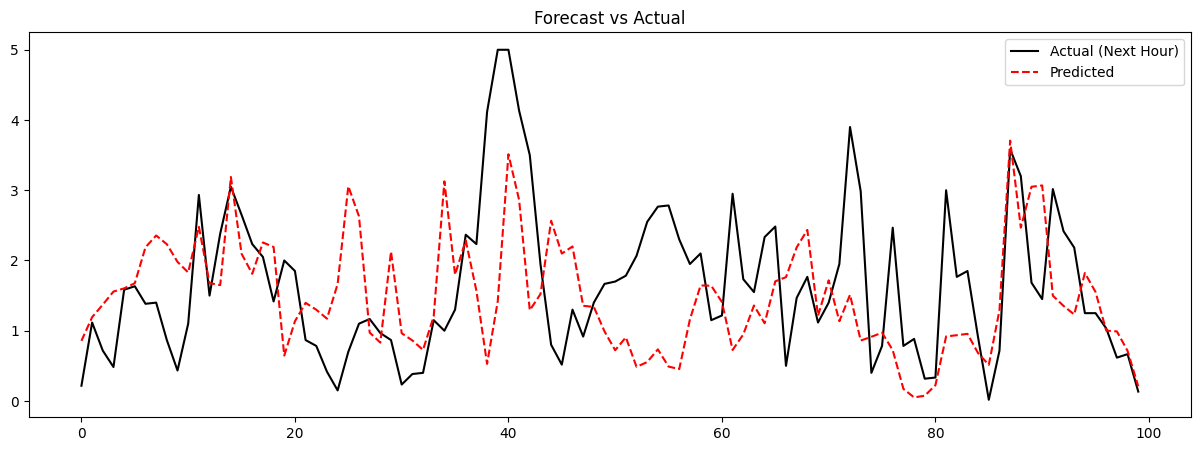

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_tune[-100:], label='Actual (Next Hour)', color='black')
plt.plot(preds[-100:], label='Predicted', color='red', linestyle='--')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()